In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from sklearn.inspection import permutation_importance
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, poisson,uniform
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
from pybaseball import cache

cache.enable()

from pybaseball import statcast
data = statcast(start_dt="2020-05-24", end_dt="2021-06-25")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:33<00:00,  1.37s/it]


In [3]:
data['pitch_type'].unique()

array(['FF', 'FS', 'SI', 'KC', 'CH', 'FC', 'SL', 'ST', 'CU', 'PO', 'CS',
       'FA', 'SV', 'KN', nan, 'EP', 'SC'], dtype=object)

In [4]:
unique_values = data['pitch_type'].unique()
pitch_dic = {value: index for index, value in enumerate(unique_values)}
data['pitch_type'] = data['pitch_type'].replace(pitch_dic)
data['pitch_type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [5]:
data

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3427,0,2021-06-25,94.7,-1.81,5.49,"Neris, Hector",642086,593576,strikeout,swinging_strike,...,2,2,1,1,2,Infield shift,Standard,226,-0.16,-0.249
3532,0,2021-06-25,94.7,-1.77,5.55,"Neris, Hector",642086,593576,NaN,swinging_strike,...,2,2,1,1,2,Infield shift,Standard,228,0.0,-0.068
3660,1,2021-06-25,84.0,-1.58,5.95,"Neris, Hector",642086,593576,NaN,called_strike,...,2,2,1,1,2,Infield shift,Standard,252,0.0,-0.039
3810,1,2021-06-25,85.7,-1.56,5.83,"Neris, Hector",624413,593576,field_out,hit_into_play,...,2,2,1,1,2,Standard,Standard,254,-0.118,-0.188
3971,2,2021-06-25,94.2,-1.97,5.74,"Neris, Hector",624413,593576,NaN,foul,...,2,2,1,1,2,Standard,Standard,214,0.0,-0.079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,0,2020-07-23,96.1,-3.28,5.13,"Scherzer, Max",543305,453286,field_out,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,227,0.022,-0.216
385,8,2020-07-23,79.7,-3.36,5.48,"Scherzer, Max",543305,453286,NaN,called_strike,...,0,0,0,0,0,Infield shift,Standard,60,0.0,-0.076
398,0,2020-07-23,96.7,-3.21,5.33,"Scherzer, Max",543305,453286,NaN,called_strike,...,0,0,0,0,0,Infield shift,Standard,224,0.0,-0.06
408,0,2020-07-23,96.1,-3.38,5.33,"Scherzer, Max",543305,453286,NaN,ball,...,0,0,0,0,0,Infield shift,Standard,226,0.0,0.06


In [6]:
### All data to numbers

#Truth
pitch_cluster_truth     = ['pitch_type']

#data_FI = data.dropna(axis=1)
data_FI = data.replace('<NA>', np.nan)
data_FI = data.fillna(0)
data_FI = data_FI.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
print(len(data_FI))
y_training = data_FI[pitch_cluster_truth]
#y_training_num = {value: index for index, value in enumerate(data_FI['pitch_type'].unique())}

train = data_FI#[pitch_cluster_variables] 
train = train.drop(['pitch_type', 'player_name', 'events', 'game_date'], axis=1)

651624


In [7]:
train

,release_speed,release_pos_x,release_pos_z,batter,pitcher,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3427,94,-1,5,642086,593576,0,0,0,0,0,...,2,2,1,1,2,0,0,226,0,0
3532,94,-1,5,642086,593576,0,0,0,0,0,...,2,2,1,1,2,0,0,228,0,0
3660,84,-1,5,642086,593576,0,0,0,0,0,...,2,2,1,1,2,0,0,252,0,0
3810,85,-1,5,624413,593576,0,0,0,0,0,...,2,2,1,1,2,0,0,254,0,0
3971,94,-1,5,624413,593576,0,0,0,0,0,...,2,2,1,1,2,0,0,214,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,96,-3,5,543305,453286,0,0,0,0,0,...,0,0,0,0,0,0,0,227,0,0
385,79,-3,5,543305,453286,0,0,0,0,0,...,0,0,0,0,0,0,0,60,0,0
398,96,-3,5,543305,453286,0,0,0,0,0,...,0,0,0,0,0,0,0,224,0,0
408,96,-3,5,543305,453286,0,0,0,0,0,...,0,0,0,0,0,0,0,226,0,0


## ---------------------------------------------------------------

## 1 pitcher

## ---------------------------------------------------------------


In [8]:
one_pitcher = data[train['pitcher'] == 593576] ## Neeris hector

In [9]:
### All data to numbers

#Truth
pitch_cluster_truth     = ['pitch_type']

#data_FI = data.dropna(axis=1)
data_FI = one_pitcher.replace('<NA>', np.nan)
data_FI = one_pitcher.fillna(0)
data_FI = data_FI.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
print(len(data_FI))
y_training_1p = data_FI[pitch_cluster_truth]
#y_training_num = {value: index for index, value in enumerate(data_FI['pitch_type'].unique())}

train_1p = data_FI#[pitch_cluster_variables] 
train_1p = train_1p.drop(['pitch_type', 'player_name', 'events', 'game_date'], axis=1)

#Splitting training data
X_train, X_valid, y_train, y_valid = train_test_split(train_1p, 
                                                        y_training_1p, 
                                                        test_size=0.20, 
                                                        random_state=42)
y_train = y_train['pitch_type']
y_valid = y_valid['pitch_type']

988


In [33]:

print(y_training_1p['pitch_type'].value_counts())

1    470
0    411
2     83
3     24
Name: pitch_type, dtype: int64


In [11]:
y_training_1p['pitch_type'] = y_training_1p['pitch_type'].replace(y_training_1p['pitch_type'].unique(), [0,1,2,3])
print(y_training_1p['pitch_type'].unique())
print(y_training_1p['pitch_type'].value_counts())

[0 1 2 3]
1    470
0    411
2     83
3     24
Name: pitch_type, dtype: int64


C:\Users\Juliu\AppData\Local\Temp\ipykernel_2856\2776652857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_training_1p['pitch_type'] = y_training_1p['pitch_type'].replace(y_training_1p['pitch_type'].unique(), [0,1,2,3])


In [12]:
print('This pitcher throws: [FF, FS, SI, SL]', )

This pitcher throws: [FF, FS, SI, SL]


### LGBM

In [13]:
import lightgbm as lgb
from lightgbm import early_stopping

In [14]:
start = time.time()
#####################################################################

lgbm = lgb.LGBMClassifier(objective='multiclass', num_classes=len(y_training_1p['pitch_type'].unique()), metric='multi_logloss')
lgbm.fit(X_train, y_train)

lgbm_feat_import = permutation_importance(lgbm, X_valid, y_valid, 
                                          n_repeats=2, 
                                          random_state=0)
#####################################################################
end = time.time()
print('Time taken: ', end-start, 'seconds')

Time taken:  2.0126192569732666 seconds


In [15]:
print('Feature importances in order:')
rating = lgbm_feat_import.importances_mean
rating.sort()
for i in range(len(rating)):
    print(f'Feature: {train_1p.columns[lgbm_feat_import.importances_mean.argsort()][i]} with rating: {rating[::-1][i]}')

Feature importances in order:
Feature: release_speed with rating: 0.09595959595959597
Feature: fielder_7 with rating: 0.06818181818181812
Feature: fielder_6 with rating: 0.0050505050505050275
Feature: fielder_5 with rating: 0.005050505050504972
Feature: fielder_4 with rating: 0.0
Feature: fielder_3 with rating: 0.0
Feature: fielder_2.1 with rating: 0.0
Feature: pitcher.1 with rating: 0.0
Feature: game_pk with rating: 0.0
Feature: release_extension with rating: 0.0
Feature: release_spin_rate with rating: 0.0
Feature: effective_speed with rating: 0.0
Feature: launch_angle with rating: 0.0
Feature: launch_speed with rating: 0.0
Feature: hit_distance_sc with rating: 0.0
Feature: sz_bot with rating: 0.0
Feature: sz_top with rating: 0.0
Feature: az with rating: 0.0
Feature: fielder_8 with rating: 0.0
Feature: fielder_9 with rating: 0.0
Feature: release_pos_y with rating: 0.0
Feature: estimated_ba_using_speedangle with rating: 0.0
Feature: if_fielding_alignment with rating: 0.0
Feature: post_

In [16]:
# Creating new data from the best found features

lgbm_feat =['release_speed', 'fielder_7', 'fielder_6', 'fielder_5']
#Splitting training data
X_train_lgbm, X_valid_lgbm, y_train_lgbm, y_valid_lgbm = train_test_split(train_1p[lgbm_feat], 
                                                        y_training_1p, 
                                                        test_size=0.20, 
                                                        random_state=42)
y_train_lgbm = y_train_lgbm['pitch_type']
y_valid_lgbm = y_valid_lgbm['pitch_type']

lgb_train = lgb.Dataset(X_train_lgbm, y_train_lgbm)
lgb_eval  = lgb.Dataset(X_valid_lgbm, y_valid_lgbm)

## Random search

In [17]:
rand_lr     = list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000))
rand_leaves = poisson(50)
rand_depth  = randint(1,50)
rand_esti   = poisson(400)
rand_params = {'learning_rate': rand_lr,
               'max_depth': rand_depth,
              'num_leaves': rand_leaves,
              'n_estimators': rand_esti}

lgbm = lgb.LGBMClassifier(objective='multiclass', num_classes=len(y_training_1p['pitch_type'].unique()), metric='multi_logloss')
n_iter_search = 20
rand_search = RandomizedSearchCV(lgbm, 
                           param_distributions=rand_params,
                           n_iter=n_iter_search,
                           cv=5,
                           return_train_score=True)#,
                          #refit=True)


In [18]:
start = time.time()
#####################################################################

rand_search.fit(X_train, y_train)
RandomSearch_results = pd.DataFrame(rand_search.cv_results_)                 
print("Random Search: \tBest parameters: ", rand_search.best_params_, f", Best scores: {rand_search.best_score_:.3f}")
#####################################################################
end = time.time()
print('Time taken: ', end-start, 'seconds')

Random Search: 	Best parameters:  {'learning_rate': 0.021458661892110785, 'max_depth': 48, 'n_estimators': 443, 'num_leaves': 47} , Best scores: 0.995
Time taken:  166.2870750427246 seconds


## Final LGBM model

In [19]:
start = time.time()
#####################################################################

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_classes': len(y_training_1p['pitch_type'].unique()),
    'metric': 'multi_logloss',
    'learning_rate': 0.23694398048588264,
    'max_depth':     28,
    #'n_estimators': 398,
    'num_leaves': 54,
    'verbose': -1
}

#model = lgb.LGBMClassifier(params,
lgbm_final = lgb.train(params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=lgb_eval,
                    callbacks=[early_stopping(10)])

#####################################################################
end = time.time()
print('Time taken: ', end-start, 'seconds')

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.210125
Time taken:  0.13315367698669434 seconds


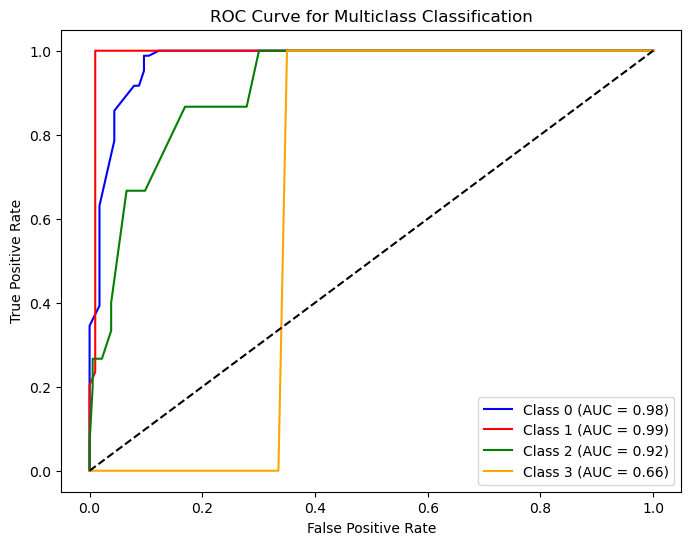

In [20]:
y_score = lgbm_final.predict(X_valid_lgbm, num_iteration=lgbm_final.best_iteration)  # Scores are floats in the range ]0,1[.

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(y_train_lgbm.unique())

y = y_training_1p['pitch_type']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_lgbm == y.unique()[i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Adjust the colors based on the number of classes

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {y.unique()[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

## ---------------------------------------------------------------

## 2 pitchers

## ---------------------------------------------------------------

In [21]:
two_pitcher = data[train['pitcher'].isin([593576, 656887])] ## Neeris hector

In [22]:
### All data to numbers

#Truth
pitch_cluster_truth     = ['pitch_type']

#data_FI = data.dropna(axis=1)
data_FI = two_pitcher.replace('<NA>', np.nan)
data_FI = two_pitcher.fillna(0)
data_FI = data_FI.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
print(len(data_FI))
y_training_2p = data_FI[pitch_cluster_truth]
#y_training_num = {value: index for index, value in enumerate(data_FI['pitch_type'].unique())}

train_2p = data_FI#[pitch_cluster_variables] 
train_2p = train_2p.drop(['pitch_type', 'player_name', 'events', 'game_date'], axis=1)

#Splitting training data
X_train, X_valid, y_train, y_valid = train_test_split(train_2p, 
                                                        y_training_2p, 
                                                        test_size=0.20, 
                                                        random_state=42)
y_train = y_train['pitch_type']
y_valid = y_valid['pitch_type']

1444


In [23]:
print(y_training_2p['pitch_type'].unique())
print(y_training_2p['pitch_type'].value_counts())

[0 1 2 6 4]
0    701
1    470
6    137
2     83
4     53
Name: pitch_type, dtype: int64


In [24]:
y_training_2p['pitch_type'] = y_training_2p['pitch_type'].replace(y_training_2p['pitch_type'].unique(), [0,1,2,3,4])
print(y_training_2p['pitch_type'].unique())
print(y_training_2p['pitch_type'].value_counts())

[0 1 2 3 4]
0    701
1    470
3    137
2     83
4     53
Name: pitch_type, dtype: int64


C:\Users\Juliu\AppData\Local\Temp\ipykernel_2856\1575853923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_training_2p['pitch_type'] = y_training_2p['pitch_type'].replace(y_training_2p['pitch_type'].unique(), [0,1,2,3,4])


In [25]:
print('This pitchers throws: [FF, FS, SI, CH, SL]' )

This pitchers throws: [FF, FS, SI, CH, SL]


## LGBM

In [26]:
start = time.time()
#####################################################################

lgbm = lgb.LGBMClassifier(objective='multiclass', num_classes=len(y_training_2p['pitch_type'].unique()), metric='multi_logloss')
lgbm.fit(X_train, y_train)

lgbm_feat_import = permutation_importance(lgbm, X_valid, y_valid, 
                                          n_repeats=2, 
                                          random_state=0)
#####################################################################
end = time.time()
print('Time taken: ', end-start, 'seconds')

Time taken:  3.5430665016174316 seconds


In [27]:
print('Feature importances in order:')
rating = lgbm_feat_import.importances_mean
rating.sort()
for i in range(len(rating)):
    print(f'Feature: {train_2p.columns[lgbm_feat_import.importances_mean.argsort()][i]} with rating: {rating[::-1][i]}')

Feature importances in order:
Feature: release_speed with rating: 0.12456747404844293
Feature: fielder_4 with rating: 0.11937716262975778
Feature: fielder_3 with rating: 0.010380622837370235
Feature: fielder_2.1 with rating: 0.00865051903114189
Feature: pitcher.1 with rating: 0.006920415224913545
Feature: game_pk with rating: 0.0017301038062284002
Feature: release_extension with rating: 0.0017301038062284002
Feature: release_spin_rate with rating: 0.0017301038062284002
Feature: fielder_5 with rating: 0.0
Feature: effective_speed with rating: 0.0
Feature: launch_speed with rating: 0.0
Feature: hit_distance_sc with rating: 0.0
Feature: sz_bot with rating: 0.0
Feature: sz_top with rating: 0.0
Feature: az with rating: 0.0
Feature: ay with rating: 0.0
Feature: vz0 with rating: 0.0
Feature: launch_angle with rating: 0.0
Feature: fielder_6 with rating: 0.0
Feature: fielder_7 with rating: 0.0
Feature: fielder_8 with rating: 0.0
Feature: post_away_score with rating: 0.0
Feature: fld_score with 

In [28]:
# Creating new data from the best found features

lgbm_feat_2p =['release_speed', 'fielder_4', 'fielder_3', 'fielder_2.1', 'pitcher.1', 'game_pk', 'release_extension', 'release_spin_rate']
#Splitting training data
X_train_lgbm, X_valid_lgbm, y_train_lgbm, y_valid_lgbm = train_test_split(train_2p[lgbm_feat_2p], 
                                                        y_training_2p, 
                                                        test_size=0.20, 
                                                        random_state=42)
y_train_lgbm = y_train_lgbm['pitch_type']
y_valid_lgbm = y_valid_lgbm['pitch_type']

lgb_train = lgb.Dataset(X_train_lgbm, y_train_lgbm)
lgb_eval  = lgb.Dataset(X_valid_lgbm, y_valid_lgbm)

In [29]:
rand_lr     = list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000))
rand_leaves = poisson(50)
rand_depth  = randint(1,50)
rand_esti   = poisson(400)
rand_params = {'learning_rate': rand_lr,
               'max_depth': rand_depth,
              'num_leaves': rand_leaves,
              'n_estimators': rand_esti}

lgbm = lgb.LGBMClassifier(objective='multiclass', num_classes=len(y_training_2p['pitch_type'].unique()), metric='multi_logloss')
n_iter_search = 20
rand_search = RandomizedSearchCV(lgbm, 
                           param_distributions=rand_params,
                           n_iter=n_iter_search,
                           cv=5,
                           return_train_score=True)#,
                          #refit=True)

In [30]:
start = time.time()
#####################################################################

rand_search.fit(X_train, y_train)
RandomSearch_results = pd.DataFrame(rand_search.cv_results_)                 
print("Random Search: \tBest parameters: ", rand_search.best_params_, f", Best scores: {rand_search.best_score_:.3f}")
#####################################################################
end = time.time()
print('Time taken: ', end-start, 'seconds')

Random Search: 	Best parameters:  {'learning_rate': 0.06138455239941795, 'max_depth': 43, 'n_estimators': 386, 'num_leaves': 46} , Best scores: 0.996
Time taken:  274.0262017250061 seconds


In [31]:
start = time.time()
#####################################################################

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_classes': len(y_training_2p['pitch_type'].unique()),
    'metric': 'multi_logloss',
    'learning_rate': 0.3271793009441616,
    'max_depth':     34,
    #'n_estimators': 398,
    'num_leaves': 42,
    'verbose': -1
}

#model = lgb.LGBMClassifier(params,
lgbm_final = lgb.train(params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=lgb_eval,
                    callbacks=[early_stopping(10)])

#####################################################################
end = time.time()
print('Time taken: ', end-start, 'seconds')

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's multi_logloss: 0.144166
Time taken:  0.16706109046936035 seconds


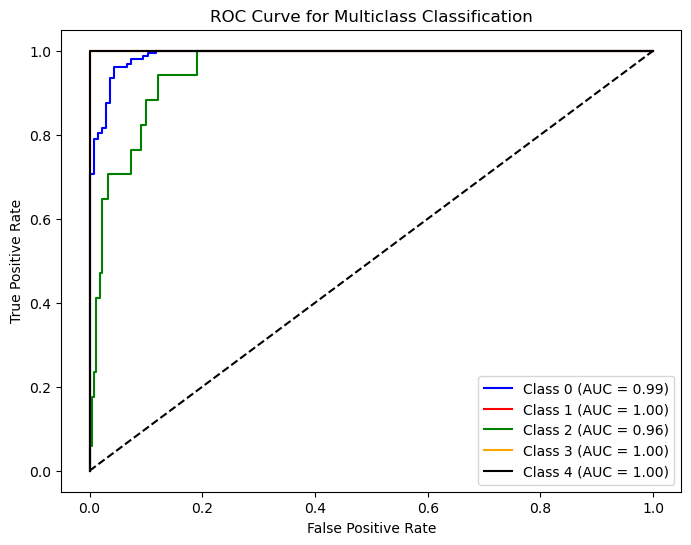

In [32]:
y_score = lgbm_final.predict(X_valid_lgbm, num_iteration=lgbm_final.best_iteration)  # Scores are floats in the range ]0,1[.

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(y_train_lgbm.unique())

y = y_training_2p['pitch_type']


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_lgbm == y.unique()[i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'black']  # Adjust the colors based on the number of classes

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {y.unique()[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

## ---------------------------------------------------------------

## ALL pitchers

## ---------------------------------------------------------------